## Generative Adverserial Network

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
from IPython.display import Image
%matplotlib inline

### Improving the quality of synthesized images using DCGAN

---

#### **Recap on to Vanilla GAN**
   - **Basic Structure**: In a Vanilla GAN, there are two primary components—a *Generator (G)* and a *Discriminator (D)*. The Generator attempts to create realistic-looking fake samples from random noise, while the Discriminator tries to distinguish real samples from the fake ones. Both components play a minimax game, constantly improving to “outsmart” each other.
   - **Objective**: The objective of the GAN is to reach a Nash equilibrium where the Generator can produce indistinguishable fake samples, and the Discriminator can no longer tell real from fake with high accuracy.

#### **Deep Convolutional GANs**

   - Deep Convolutional GANs (DCGANs) introduced convolutional layers to both the Generator and Discriminator, revolutionizing how GANs handle image generation. [Source: *Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks*](https://arxiv.org/abs/1511.06434)

   - **How DCGAN Improves over Vanilla GAN**:
     - *Architecture Adjustments*: DCGAN replaces fully connected layers with convolutional and transposed convolutional layers, which help capture spatial hierarchies in images, improving output quality.
     - *Batch Normalization*: By adding batch normalization, DCGAN helps stabilizing training and accelerates convergence. Batch normalization in both the Generator and Discriminator layers helps address training instabilities.
     - *Removing Pooling Layers*: Instead of pooling, DCGAN uses strided convolutions, giving the network more flexibility and reducing information loss, thus addressing mode collapse partially by better preserving details across image generations.

![Figure from https://arxiv.org/pdf/1511.06434](https://pytorch.org/tutorials/_images/dcgan_generator.png)


**But how can we go from 1D to a 2D picture?**


### What is Transposed Convolution?

**Transposed convolution**—also called **deconvolution** or **fractionally strided convolution**—is a technique used in deep learning to **upsample** feature maps by increasing their spatial resolution. This is useful in tasks like **image generation**, **semantic segmentation**, and **super-resolution**, where high-resolution outputs must be reconstructed from lower-resolution inputs.

---

### Convolution vs. Transposed Convolution

In a **standard convolution**, a kernel (filter) slides over the input feature map to produce a **smaller output**, depending on stride, padding, and kernel size.

In contrast, a **transposed convolution** performs the **inverse**: it transforms a **smaller input** into a **larger output**, effectively reversing the spatial downsampling done by a regular convolution.

---

### How Transposed Convolution Works

**a. Input Expansion**  
The input feature map is **expanded** by inserting **spaces (typically zeros)** between its elements. This creates a larger intermediate map that simulates upsampling.

**b. Kernel Application**  
A convolutional kernel is then **slid over the expanded input**. Unlike standard convolution, the kernel **spreads each input value** over a region of the output, causing **overlapping contributions** (overlapping typically occurs when stride < kernel size).

**c. Overlap Summation**  
Where multiple kernel applications overlap, their values are **summed** to produce the final upsampled feature map.

---

### Mathematical Formulation

The output size \( o \) of a **1D transposed convolution** is calculated as:

$$
o = (n - 1) \cdot s - 2p + k + o_p
$$

Where (slightly different meanings compared to those you are used to):

- \( n \): input size  
- \( s \): stride --- The stride option is used to set how far apart the original cells are in the intermediate grid. Unlike normal convolution, here the stride is not used to decide how the kernel moves - the kernel is moved across this intermediate grid in step sizes of 1. This step size is always 1.
- \( p \): padding --- e.g., if the padding is set to 1, we remove 1 ring from around the intermediate grid.
- \( k \): kernel size  
- \( o$_p$ \): output padding (optional, allows fine control over output size)

For **2D transposed convolutions**, apply this formula separately for height and width.

---

This allows for precise control of the output dimensions, enabling networks to learn **how to upsample features** in a differentiable and trainable way.




---


**Implementation in Deep Learning Frameworks**

Most deep learning frameworks provide built-in functions for transposed convolution:

- **PyTorch**: [`torch.nn.ConvTranspose2d`](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) applies a 2D transposed convolution operator over an input image composed of several input planes.
- **TensorFlow/Keras**: [`tf.keras.layers.Conv2DTranspose`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose) is used to apply a 2D transposed convolution layer.

---

Here is demonstraion of deconvolution operation

![](https://blogger.googleusercontent.com/img/b/R29vZ2xl/AVvXsEiGKShf5RPVMntFYtLQhNfI4wVb4l7-4wzfSbOW4YOIpsX2RyTFrPZgbaIFfZGdbMJmiPgNNI4SFLkoE2YC4PZFOfdWVgLL5N97K6JYDcKfBx4v3sLmO6zwRcbg2vcb2RCblNeLQmebC-Mm/s1600/appendix_C_eg_5.png)


Figure [Source: Make your own neural network](http://makeyourownneuralnetwork.blogspot.com/2020/02/calculating-output-size-of-convolutions.html) --- take a look at this source for other examples. Very useful!

### Batch normalization

This is as well essential for DCGAN implementation. We had discussed about Batch Norm in the [Lecture on GradCAM](https://cfteach.github.io/NNDL_2025/lec13_Introduction_to_X_AI_via_grad_cam.html#batch-normalization)


![](https://github.com/cfteach/NNDL_DATA621/blob/webpage-src/DATA621/DATA621/images/batch_norm.png?raw=true)

### Implementing the generator and discriminator


The generator and discriminator for MNIST digit dataset will be explained in the following:




<!--![](https://github.com/cfteach/NNDL_DATA621/blob/webpage-src/DATA621/DATA621/images/generator.png?raw=true)


The discriminator for MNIST digit dataset will be

![](https://github.com/cfteach/NNDL_DATA621/blob/webpage-src/DATA621/DATA621/images/discriminator.png?raw=true)
-->


In [3]:
import torch


print(torch.__version__)
print("GPU Available:", torch.cuda.is_available())

if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = "cpu"

2.6.0+cu124
GPU Available: True


In [4]:
import torch.nn as nn
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

### Train the DCGAN model

In [5]:
import torchvision
from torchvision import transforms


image_path = './'
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))
])
mnist_dataset = torchvision.datasets.MNIST(root=image_path,
                                           train=True,
                                           transform=transform,
                                           download=True)

batch_size = 128

torch.manual_seed(1)
np.random.seed(1)

## Set up the dataset
from torch.utils.data import DataLoader
mnist_dl = DataLoader(mnist_dataset, batch_size=batch_size,
                      shuffle=True, drop_last=True)

# When using a DataLoader with batching, your dataset might not divide evenly by the batch size.
# The drop_last parameter tells PyTorch what to do with the last batch if it’s smaller than the specified batch size.


In [6]:
iter_mnist_dl = iter(mnist_dl)
images, labels = next(iter_mnist_dl)
print(images.shape)
print(labels.shape)

torch.Size([128, 1, 28, 28])
torch.Size([128])


In [8]:
def make_generator_network(input_size, n_filters):
    #nn.ConvTranspose2d(in_channels = input_size,
    #                   out_channels = n_filters*4,
    #                   kernel_size = 4,
    #                   stride = 1,
    #                   padding = 0,
    #                   output_padding = 0,
    #                   bias = False
    #                   )
    model = nn.Sequential(
        # 1. Input: (batch_size, 100, 1, 1) → latent vector
        nn.ConvTranspose2d(in_channels = input_size,    # latent vector size (e.g., 100)
                           out_channels = n_filters*4,  # how many filters to output (feature maps)
                           kernel_size = 4,             # size of the filters
                           stride = 1,                  # move by 1 pixel
                           padding = 0,                 # no padding
                           bias=False),                 # bias is disabled
        # → (batch_size, 128, 4, 4) --- assuming n_channels = n_filters * 4 = 32 * 4
        nn.BatchNorm2d(n_filters*4),
        nn.LeakyReLU(0.2),

        # 2. Upsample to 7x7
        nn.ConvTranspose2d(n_filters*4, n_filters*2, 3, 2, 1, bias=False),
        # → (batch_size, 64, 7, 7)
        nn.BatchNorm2d(n_filters*2),
        nn.LeakyReLU(0.2),

        # 3. Upsample to 14x14
        nn.ConvTranspose2d(n_filters*2, n_filters, 4, 2, 1, bias=False),
        # → (batch_size, 32, 14, 14)
        nn.BatchNorm2d(n_filters),
        nn.LeakyReLU(0.2),

        # 4. Final: upsample to 28x28
        nn.ConvTranspose2d(n_filters, 1, 4, 2, 1, bias=False),
        nn.Tanh())
    return model

dropout_rate = 0.2

class Discriminator(nn.Module):
    def __init__(self, n_filters):
        super().__init__()
        self.network = nn.Sequential(
            # Input: (batch_size, 1, 28, 28)

            # Conv2d: in_channels=1, out_channels=32, kernel=4, stride=2, padding=1
            nn.Conv2d(1, n_filters, 4, 2, 1, bias=False),
            # Output: (batch_size, 32, 14, 14)
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),  # Dropout after activation

            # Conv2d: in_channels=32, out_channels=64, kernel=4, stride=2, padding=1
            nn.Conv2d(n_filters, n_filters*2, 4, 2, 1, bias=False),
            # Output: (batch_size, 64, 7, 7)
            nn.BatchNorm2d(n_filters * 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),  # Dropout after activation

            # Conv2d: in_channels=64, out_channels=128, kernel=3, stride=2, padding=1
            nn.Conv2d(n_filters*2, n_filters*4, 3, 2, 1, bias=False),
            # Output: (batch_size, 128, 4, 4)
            nn.BatchNorm2d(n_filters*4),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),  # Dropout after activation

            # Conv2d: in_channels=128, out_channels=1, kernel=4, stride=1, padding=0
            nn.Conv2d(n_filters*4, 1, 4, 1, 0, bias=False),
            # Output: (batch_size, 1, 1, 1)
            nn.Sigmoid())

    def forward(self, input):
        output = self.network(input)
        return output.view(-1, 1).squeeze(0)


In [9]:
z_size = 100
image_size = (28, 28)
n_filters = 32
gen_model = make_generator_network(z_size, n_filters).to(device)
print(gen_model)
disc_model = Discriminator(n_filters).to(device)
print(disc_model)

Sequential(
  (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2)
  (3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2)
  (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2)
  (9): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): Tanh()
)
Discriminator(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.2, inplace=False)
    (3): Conv2d(32, 64, kernel_s

In [10]:
## Loss function and optimizers:
loss_fn = nn.BCELoss()
g_optimizer = torch.optim.Adam(gen_model.parameters(), 0.0003, betas=(0.75, 0.999))
d_optimizer = torch.optim.Adam(disc_model.parameters(), 0.0002)

# Generator LR slightly higher to help it catch up
#g_optimizer = torch.optim.Adam(gen_model.parameters(), lr=2e-4, betas=(0.5, 0.999))
#d_optimizer = torch.optim.Adam(disc_model.parameters(), lr=1e-4, betas=(0.5, 0.999))

In [11]:
def create_noise(batch_size, z_size, mode_z):
    if mode_z == 'uniform':
        input_z = torch.rand(batch_size, z_size, 1, 1)*2 - 1
    elif mode_z == 'normal':
        input_z = torch.randn(batch_size, z_size, 1, 1)
    return input_z

In [12]:
## Train the discriminator
def d_train(x):
    disc_model.zero_grad()

    # Train discriminator with a real batch
    batch_size = x.size(0)
    x = x.to(device)
    d_labels_real = torch.ones(batch_size, 1, device=device)

    d_proba_real = disc_model(x)
    d_loss_real = loss_fn(d_proba_real, d_labels_real)

    # Train discriminator on a fake batch
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_output = gen_model(input_z)

    d_proba_fake = disc_model(g_output)
    d_labels_fake = torch.zeros(batch_size, 1, device=device)
    d_loss_fake = loss_fn(d_proba_fake, d_labels_fake)

    # gradient backprop & optimize ONLY D's parameters
    d_loss = d_loss_real + d_loss_fake
    d_loss.backward()
    d_optimizer.step()

    return d_loss.data.item(), d_proba_real.detach(), d_proba_fake.detach(), input_z


In [13]:
## Train the generator
def g_train(x): #,input_z
    gen_model.zero_grad()


    batch_size = x.size(0)
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_labels_real = torch.ones((batch_size, 1), device=device)

    g_output = gen_model(input_z)                 # G(z)
    d_proba_fake = disc_model(g_output)           # D(G(z))

    g_loss = loss_fn(d_proba_fake, g_labels_real) # loss = BCE(D(G(z)), 1)

    # gradient backprop & optimize ONLY G's parameters
    g_loss.backward()
    g_optimizer.step()

    return g_loss.data.item()


In [14]:
def show_generated_images(images):
    images = (images + 1) / 2
    grid = torchvision.utils.make_grid(images, nrow=8)
    plt.figure(figsize=(8, 8))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.axis("off")
    plt.show()

def create_samples(g_model, input_z, batch_size):
    g_output = g_model(input_z)
    images = torch.reshape(g_output, (batch_size, *image_size))
    return (images+1)/2.0

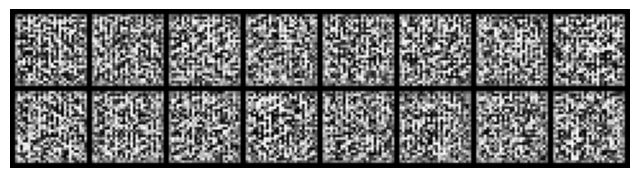

In [15]:
with torch.no_grad():
    z = torch.randn(16, z_size, 1, 1).to(device)
    untrained_imgs = gen_model(z)
    show_generated_images(untrained_imgs)

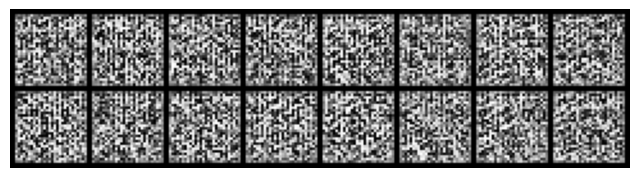

Epoch 001 | Avg Losses >> G/D 1.5605/1.1140 [D-Real: 0.6317 D-Fake: 0.3734]


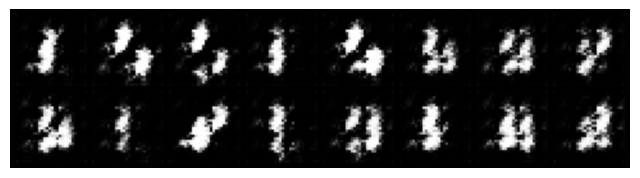

Epoch 002 | Avg Losses >> G/D 1.2857/1.2526 [D-Real: 0.5788 D-Fake: 0.4015]


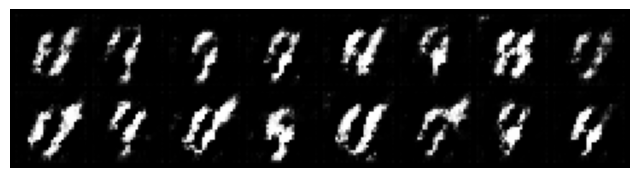

Epoch 003 | Avg Losses >> G/D 1.1793/1.1939 [D-Real: 0.5863 D-Fake: 0.4030]


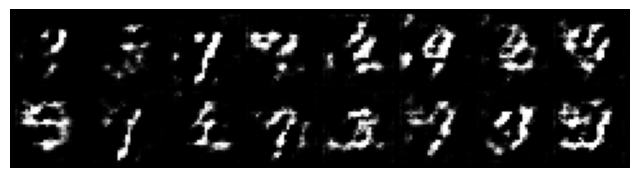

Epoch 004 | Avg Losses >> G/D 1.1337/1.2067 [D-Real: 0.5834 D-Fake: 0.4089]


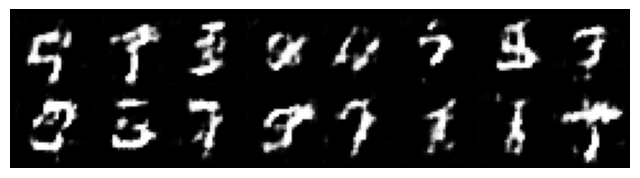

Epoch 005 | Avg Losses >> G/D 1.1126/1.1822 [D-Real: 0.5889 D-Fake: 0.4044]


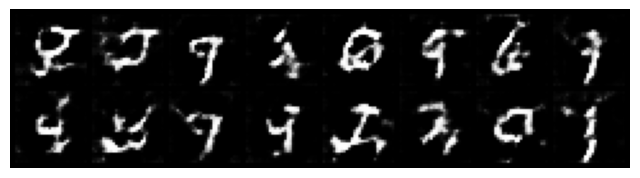

Epoch 006 | Avg Losses >> G/D 1.0256/1.2128 [D-Real: 0.5772 D-Fake: 0.4180]


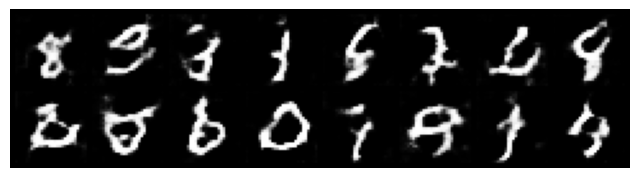

Epoch 007 | Avg Losses >> G/D 0.9858/1.2499 [D-Real: 0.5684 D-Fake: 0.4296]


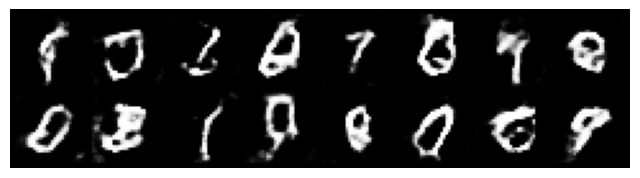

Epoch 008 | Avg Losses >> G/D 0.9558/1.2521 [D-Real: 0.5645 D-Fake: 0.4341]


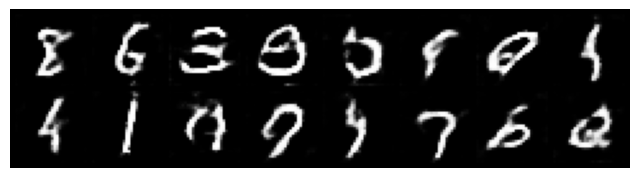

Epoch 009 | Avg Losses >> G/D 0.9551/1.2497 [D-Real: 0.5647 D-Fake: 0.4342]


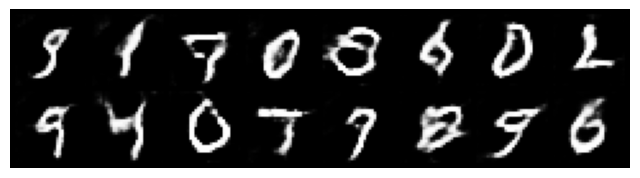

Epoch 010 | Avg Losses >> G/D 0.9531/1.2424 [D-Real: 0.5651 D-Fake: 0.4332]


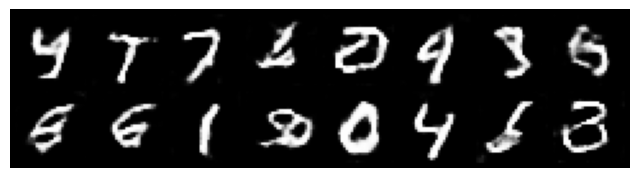

Epoch 011 | Avg Losses >> G/D 0.9673/1.2056 [D-Real: 0.5750 D-Fake: 0.4246]


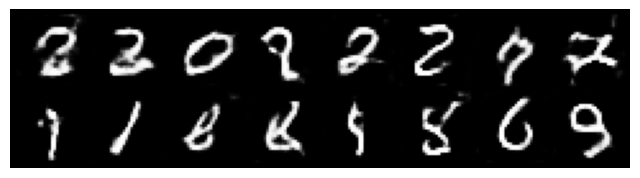

Epoch 012 | Avg Losses >> G/D 0.9952/1.1887 [D-Real: 0.5804 D-Fake: 0.4176]


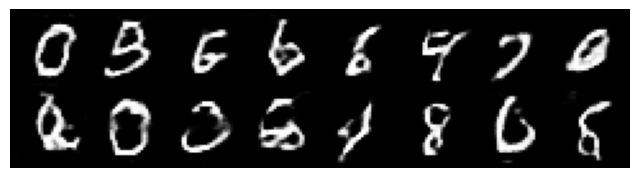

Epoch 013 | Avg Losses >> G/D 0.9953/1.2010 [D-Real: 0.5787 D-Fake: 0.4204]


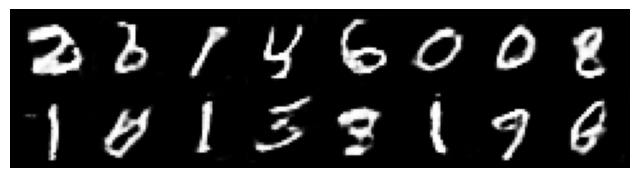

Epoch 014 | Avg Losses >> G/D 1.0161/1.1644 [D-Real: 0.5882 D-Fake: 0.4095]


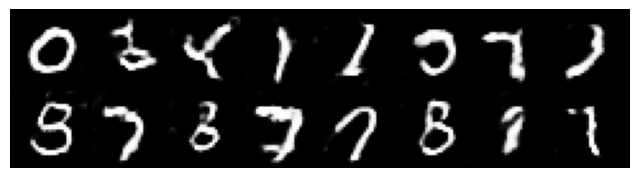

Epoch 015 | Avg Losses >> G/D 1.0416/1.1547 [D-Real: 0.5931 D-Fake: 0.4053]


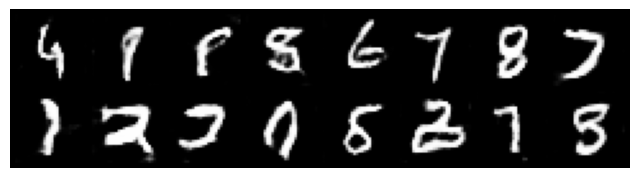

Epoch 016 | Avg Losses >> G/D 1.0430/1.1502 [D-Real: 0.5957 D-Fake: 0.4027]


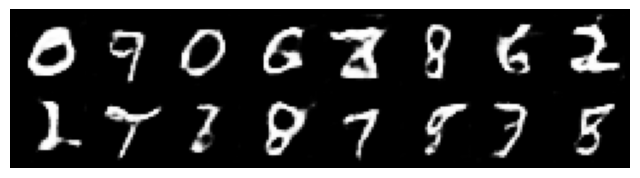

Epoch 017 | Avg Losses >> G/D 1.0617/1.1478 [D-Real: 0.5971 D-Fake: 0.4012]


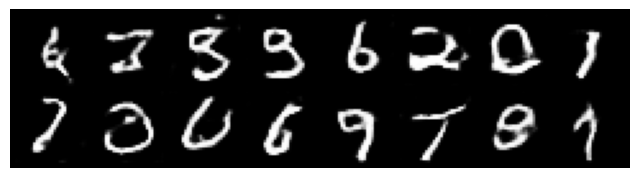

Epoch 018 | Avg Losses >> G/D 1.0743/1.1322 [D-Real: 0.6016 D-Fake: 0.3963]


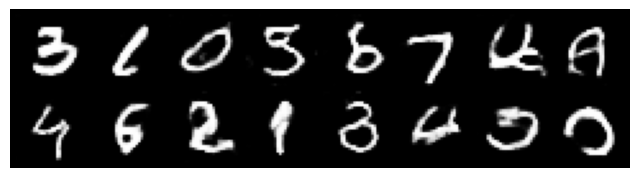

Epoch 019 | Avg Losses >> G/D 1.0814/1.1344 [D-Real: 0.6029 D-Fake: 0.3957]


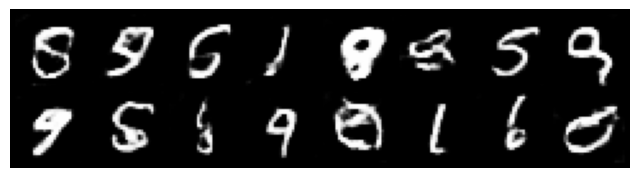

Epoch 020 | Avg Losses >> G/D 1.0939/1.1151 [D-Real: 0.6087 D-Fake: 0.3894]


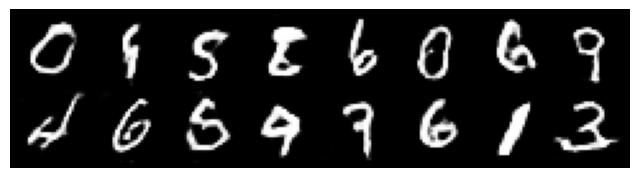

In [16]:
mode_z = 'uniform'
fixed_z = create_noise(batch_size, z_size, mode_z).to(device)


epoch_samples = []

all_d_losses = []
all_g_losses = []

all_d_real = []
all_d_fake = []

num_epochs = 20
torch.manual_seed(1)

# Plot noise images produced by the generator before training
with torch.no_grad():
    z = torch.randn(16, z_size, 1, 1).to(device)
    fake_imgs = gen_model(z)
    show_generated_images(fake_imgs)

for epoch in range(1, num_epochs+1):
    gen_model.train()
    disc_model.train()
    # Activates layers like Dropout and BatchNorm in training mode
    # Enables gradient updates

    d_losses, g_losses = [], []
    d_vals_real, d_vals_fake = [], []

    for i, (x, _) in enumerate(mnist_dl):
        d_loss, d_proba_real, d_proba_fake, input_z = d_train(x)
        d_losses.append(d_loss)
        g_losses.append(g_train(x)) # input_z

        d_vals_real.append(d_proba_real.mean().cpu())
        d_vals_fake.append(d_proba_fake.mean().cpu())

    all_d_losses.append(torch.tensor(d_losses).mean())
    all_g_losses.append(torch.tensor(g_losses).mean())
    all_d_real.append(torch.tensor(d_vals_real).mean())
    all_d_fake.append(torch.tensor(d_vals_fake).mean())

    print(f'Epoch {epoch:03d} | Avg Losses >>'
          f' G/D {all_g_losses[-1]:.4f}/{all_d_losses[-1]:.4f}'
          f' [D-Real: {all_d_real[-1]:.4f} D-Fake: {all_d_fake[-1]:.4f}]')

    gen_model.eval()
    # Deactivates Dropout, uses running stats for BatchNorm
    # Freezes layers for inference

    with torch.no_grad():
        z = torch.randn(16, z_size, 1, 1).to(device)
        fake_imgs = gen_model(z)
        show_generated_images(fake_imgs)

    epoch_samples.append(
        create_samples(gen_model, fixed_z, batch_size).detach().cpu().numpy())

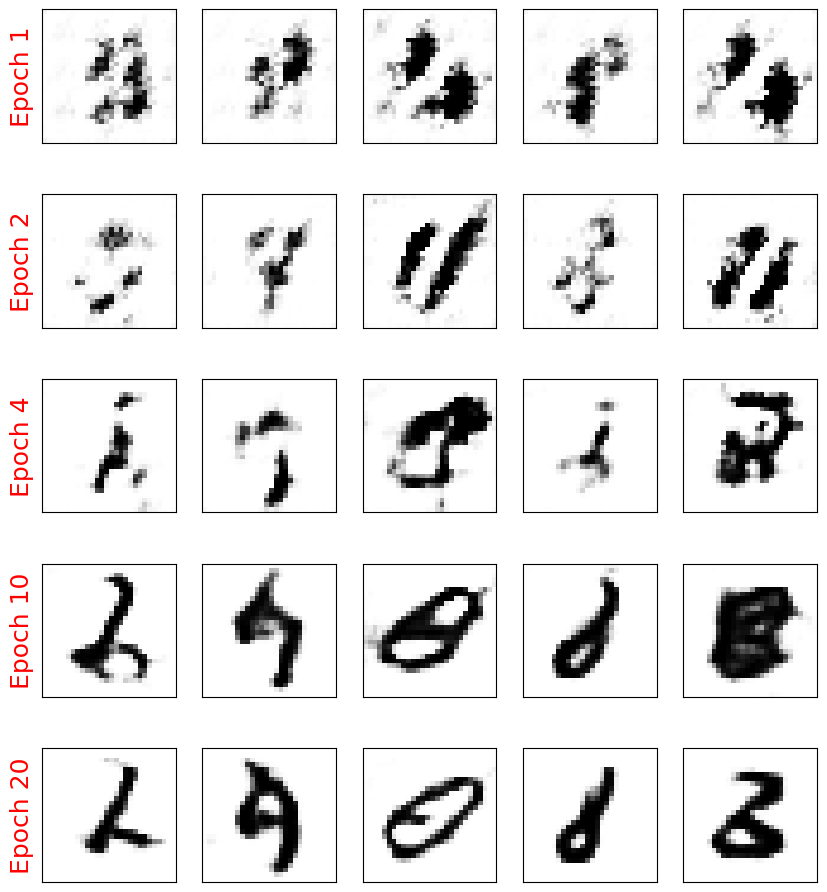

In [17]:
selected_epochs = [1, 2, 4, 10, 20]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i*5+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(
                -0.06, 0.5, f'Epoch {e}',
                rotation=90, size=18, color='red',
                horizontalalignment='right',
                verticalalignment='center',
                transform=ax.transAxes)

        image = epoch_samples[e-1][j]
        ax.imshow(image, cmap='gray_r')

plt.show()

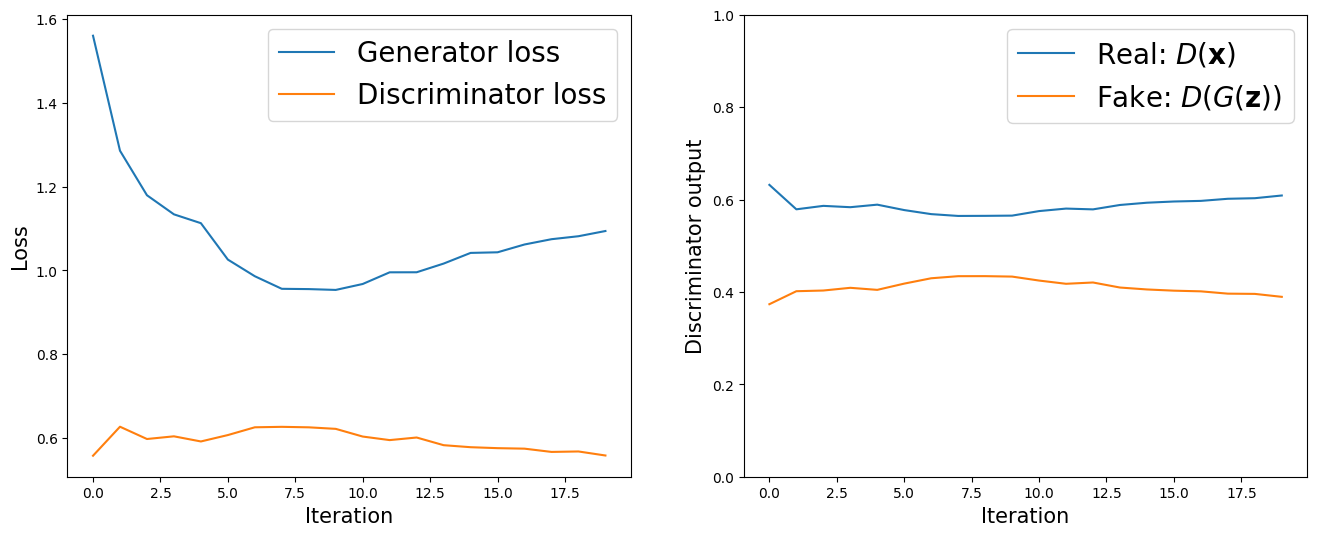

In [18]:
fig = plt.figure(figsize=(16, 6))

## Plotting the losses
ax = fig.add_subplot(1, 2, 1)

plt.plot(all_g_losses, label='Generator loss')
half_d_losses = [all_d_loss/2 for all_d_loss in all_d_losses]
plt.plot(half_d_losses, label='Discriminator loss')
plt.legend(fontsize=20)
#plt.ylim(0,2)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Loss', size=15)

## Plotting the outputs of the discriminator
ax = fig.add_subplot(1, 2, 2)
plt.plot(all_d_real, label=r'Real: $D(\mathbf{x})$')
plt.plot(all_d_fake, label=r'Fake: $D(G(\mathbf{z}))$')
plt.legend(fontsize=20)
plt.ylim(0,1)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Discriminator output', size=15)

plt.show()



---



### Limitations of DCGAN

DCGAN improves stability and sample quality over vanilla GANs by introducing convolutional layers, BatchNorm, and non-linearities. However, it still suffers from mode collapse and training instability, especially in more complex datasets. While its architectural choices help capture spatial correlations effectively, it does not fundamentally solve adversarial loss issues, which can lead to vanishing gradients and poor convergence.




---


Assessing the quality of GANs (and other generative models) is not starightfoward. Take a look at this example, where obviously the quality of the generated is visually good, but the behavior of the metrics 'discriminator loss' and 'generator loss' is difficult to interpret.


<img src="https://raw.githubusercontent.com/cfteach/NNDL_2025/webpage-src/NNDL_2025/NNDL_2025/images/GAN_difficult_behavior.png" alt="vanilla GAN" width="1000"/>









---



### How to assess the quality of Generation?

* This is a great paper to read on the problems of Vanilla GAN Source: [Why are Generative Adversarial Networks so Fascinating and Annoying](https://ieeexplore.ieee.org/document/9266012)?

* How can we measure the quality of our generations. More importantly, How can one determine if the model simply did not memorize the patterns and are reproducing them?


#### Dissimilarity measures between two distributions


Check out other metrics for dissimilarity from the reference book.
<img src="https://raw.githubusercontent.com/cfteach/NNDL_2025/webpage-src/NNDL_2025/NNDL_2025/images/Dis-similarity.png" alt="dissimilarity" width="600"/>



<img src="https://raw.githubusercontent.com/cfteach/NNDL_2025/webpage-src/NNDL_2025/NNDL_2025/images/Dis-similarity-example.png?raw=true" alt="dissimilarity example" width="600"/>



In the next lecture we will take a look at Wasserstein GAN (WGAN), that uses the Wasserstein Distance (Earth Mover’s Distance), a Better Metric for GANs to improve the training stability and solve issues like mode collapse that often plague traditional GANs (like DCGANs).



---



### Key Differences from Traditional GANs

| **Aspect**                 | **Traditional GAN**                                 | **WGAN**                                                                 |
|---------------------------|------------------------------------------------------|-------------------------------------------------------------------------|
| **Loss function**          | Binary Cross Entropy (JS divergence)                | Wasserstein (Earth Mover) distance                                      |
| **Discriminator output**   | Probability (0–1 with sigmoid)                      | Unbounded real number (no sigmoid)                                      |
| **Loss interpretability**  | Doesn’t correlate with image quality                | Lower loss ≈ better generated samples                                   |
| **Training stability**     | Often unstable, can collapse                        | Much more stable                                                        |
| **Label smoothing/flipping** | Common tricks                                    | Not needed                                                              |
| **Gradient handling**      | No constraint                                       | Requires Lipschitz constraint (via weight clipping or gradient penalty) |
